In [1]:
import numpy as np

In [120]:
class DeepNN():
    def __init__(self, X, Y, dims_of_layers, activations, alpha = 0.01):
        #dims_of_layers - list of number of units in each layer (first element - num of features in input)
        #activations - activation function applied to each layer
        
        #dims_of_layers[0] - n of features in input
        #activations[0] - activation for first hidden layer
        #we support only 3 activation funcs: linear, sigmoid, relu
        
        #X.shape should be (n_features, m_examples)
        #Y.shape should be (1, m_examples)
        self.X = X
        self.Y = Y
        
        self.m_examples = X.shape[1]
        
        self.dims_of_layers = dims_of_layers
        self.n_layers = len(activations)
        
        self.activations = activations
        self.params = dict()
        
        self.learning_history = []
        self.alpha = alpha
        
        #setting cache dicts for backpropogation
        
        self.cache = dict()
            
    def initialize_params(self):
        
        for i in range(1, len(self.activations) + 1):
            
            #setting parameters layer by layer
            self.params["W" + str(i)] = np.random.randn(self.dims_of_layers[i], self.dims_of_layers[i-1])
            self.params["b" + str(i)] = np.zeros((self.dims_of_layers[i], 1))
            
     
    
    def activation(self, Z, function="linear"):
        if function == "linear":
            return Z
        
        if function == "sigmoid":
            return 1 / (1 + np.exp(-Z))
        
        if function == "relu":
            return Z * (Z > 0)
        
        
    def deriv_activation(self, Z, function):
        if function == "linear":
            return 1.
    
        if function == "sigmoid":
            sigm_z = self.activation(Z, "sigmoid")
            
            return sigm_z *(1 - sigm_z)
        
        if function == "relu":
            return 1. * (Z > 0)
    
    
    
    def forward_propogation(self, X):
        
        #X.shape = (n_features, m_examples)
        
        A_prev = X
        self.cache["A0"]  = A_prev
        
        Z_current = np.dot(self.params["W1"], A_prev) + self.params["b1"]
        A_current = self.activation(Z_current, function=self.activations[0])
        
        self.cache["Z1"] = Z_current
        self.cache["A1"] = A_current
        
        for i in range(1, len(self.activations)):
            A_prev = A_current
            
            #A_prev - cache["A" + str(i)]
            Z_current = np.dot(self.params["W" + str(i+1)], A_prev) + self.params["b" + str(i+1)]
            A_current = self.activation(Z_current, function=self.activations[i])
            
            #keeping values in cache for backprop
            self.cache["Z" + str(i+1)] = Z_current
            self.cache["A" + str(i+1)] = A_current            

            
        predictions = A_current
        
        return predictions
        
    def compute_cost(self, predictions, cost_function="cross_entropy"):
        #leave cost func as a parameter 
        #so that we can use it futher not only for classification
        
        
        
        
        if cost_function == "cross_entropy":
            
            #lets cut off a  tiny constant to avoid log0 problem
            epsilon = 10 ** -15
            
            predictions = np.clip(predictions, epsilon, 1-epsilon)
            
            #BinaryCrossEntropy
        
            cost = (self.Y * np.log(predictions) + 
                    (1 - self.Y) * np.log(1 - (predictions)) ) * (-1 / self.m_examples)
            
            cost = np.sum(cost, axis=1, keepdims=True) #sum up the columns
            
        #we will have more cost functions here later...
        
        return cost
    
    def deriv_of_cost(self, predictions, cost_function="cross_entropy"):
        
        if cost_function == "cross_entropy":
            
            #avoiding division by zero
            epsilon = 10 ** -15
            predictions = np.clip(predictions, epsilon, 1-epsilon)
            
            dAL = (predictions - self.Y) / (predictions * (1 - predictions))
            
        #we will have more cost functions here later...
        
        return dAL
            
    
    def back_propogation(self, predictions, cost_func="cross_entropy"):
        
        L = self.n_layers
        
        grads_cache = dict()

        for i in range(L, 0, -1):
            if i == L:
                dA_i = self.deriv_of_cost(predictions, cost_function=cost_func)
            else:
                
                dA_i = np.dot(self.params["W" + str(i+1)].T, grads_cache["dZ" + str(i+1)])
    
    
            grads_cache["dA" + str(i)] = dA_i
            activation_i = self.activations[-i]
            
            Z_i = self.cache["Z" + str(i)]
            A_prev = self.cache["A" + str(i-1)]
            W_i = self.params["W" + str(i)]
            
            dZ_i = dA_i * self.deriv_activation(Z_i, activation_i)
            
            #computing derivs for W, b
            dW_i = (1 / self.m_examples) * np.dot(dZ_i, A_prev.T)
            db_i = (1/ self.m_examples) * np.sum(dZ_i, axis=1, keepdims=True)
            
            
            #storing gradients
            grads_cache["dZ" + str(i)] = dZ_i
            grads_cache["dW" + str(i)] = dW_i
            grads_cache["db" + str(i)] = db_i
            
        return grads_cache
    
    def update_params(self, grads):
        
        for i in range(1, self.n_layers + 1):
            
            #updating by Gradient Descent
            self.params["W" + str(i)] -=  self.alpha * grads["dW" + str(i)]
            self.params["b" + str(i)] -= self.alpha * grads["db" + str(i)]
    
    
    def fit(self, epochs=100, cost_func="cross_entropy"):
        
        #fitting process
        
        #initialize random params
        
        history = []
        self.initialize_params()
        
        
        for epoch in range(0, epochs + 1):
            
            predictions = self.forward_propogation(self.X)
            
            #computing cost function
            cost = np.round(self.compute_cost(predictions, cost_func), 6)
            history.append(cost)
            
            print("Epoch #{},  {} == {}".format(epoch, cost_func, cost))
            
            #computing gradients
            grads = self.back_propogation(predictions, cost_func="cross_entropy")
            
            #update params using Gradient Descent
            self.update_params(grads)
        
        return history

## Trying my DeepNN on syntetic dataset for binary classification



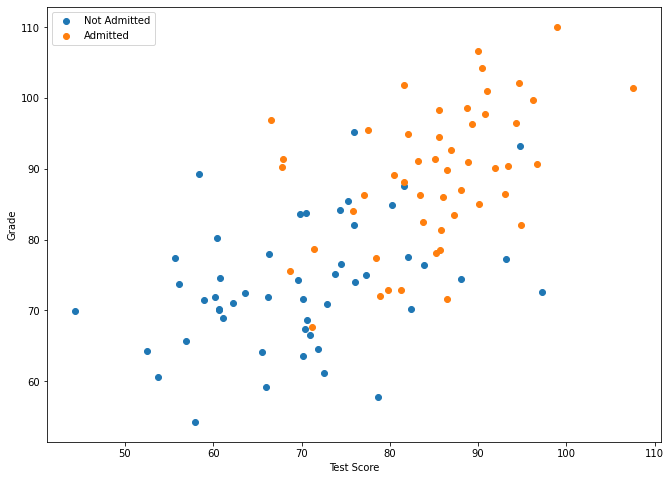

In [121]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Trying on a data

np.random.seed(2004)

# Generate data for not admitted students
mean_not_admitted = [70, 75]
cov_not_admitted = [[100, 50], [50, 100]]
not_admitted = np.random.multivariate_normal(mean_not_admitted, cov_not_admitted, size=50)

# Generate data for admitted students
mean_admitted = [85, 90]
cov_admitted = [[100, 50], [50, 100]]
admitted = np.random.multivariate_normal(mean_admitted, cov_admitted, size=50)

# Combine the data
X = np.vstack((not_admitted, admitted))
y = np.hstack((np.zeros(50), np.ones(50)))



# Plot the generated data

plt.figure(figsize=(11, 8))
plt.scatter(not_admitted[:, 0], not_admitted[:, 1], label="Not Admitted")
plt.scatter(admitted[:, 0], admitted[:, 1], label="Admitted")
plt.xlabel("Test Score")
plt.ylabel("Grade")
plt.legend()
plt.show()

In [122]:
#my DeepNN 

X_train,  X_test, y_train,y_test = train_test_split(X, y, random_state=1)




#transform for our NN

X_train = X_train.T
X_test = X_test.T

y_train = y_train.reshape(-1, 1).T
y_test = y_test.reshape(-1, 1).T


units = [X.shape[1], 5, 3, 1]
activations = ["relu", "relu", "sigmoid"]




deepnn = DeepNN(X_train, y_train, units, activations, alpha = 0.01)



In [123]:
deepnn.fit(100)

Epoch #0,  cross_entropy == [[18.421107]]
Epoch #1,  cross_entropy == [[16.118096]]
Epoch #2,  cross_entropy == [[16.118096]]
Epoch #3,  cross_entropy == [[16.118096]]
Epoch #4,  cross_entropy == [[16.118096]]
Epoch #5,  cross_entropy == [[16.118096]]
Epoch #6,  cross_entropy == [[16.118096]]
Epoch #7,  cross_entropy == [[16.118096]]
Epoch #8,  cross_entropy == [[16.118096]]
Epoch #9,  cross_entropy == [[16.118096]]
Epoch #10,  cross_entropy == [[16.118096]]
Epoch #11,  cross_entropy == [[16.118096]]
Epoch #12,  cross_entropy == [[16.118096]]
Epoch #13,  cross_entropy == [[16.118096]]
Epoch #14,  cross_entropy == [[16.118096]]
Epoch #15,  cross_entropy == [[16.118096]]
Epoch #16,  cross_entropy == [[16.118096]]
Epoch #17,  cross_entropy == [[16.118096]]
Epoch #18,  cross_entropy == [[16.118096]]
Epoch #19,  cross_entropy == [[16.118096]]
Epoch #20,  cross_entropy == [[16.118096]]
Epoch #21,  cross_entropy == [[16.118096]]
Epoch #22,  cross_entropy == [[16.118096]]
Epoch #23,  cross_ent

/tmp/ipykernel_4766/2651106991.py:45: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


[array([[18.421107]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16.118096]]),
 array([[16

In [125]:
deepnn.forward_propogation(X_test)

/tmp/ipykernel_4766/2651106991.py:45: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-Z))


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]])